# News Mood
## John M Warlop

# Dependencies

In [1]:
import tweepy
import json
import pandas as pd
import requests
import pickle

# Constants

In [2]:
handles = {'BBC':'@BBC', 'CBS':'@CBS', 'NYTimes':'@nytimes', 'Fox':'@FoxNews', 'CNN':'@CNN'}
type_handles = ['compound','neu','neg','pos','dtime']

# Functions

In [3]:
def get_keys():
    s_fname = 'api_keys'
    api_keys = {}
    with open(s_fname) as f:
        api_keys = json.load(f)
    f.close()
    return(api_keys)

def pickle_it(data,fname):
    import pickle
    pckl_out = open(fname,"wb")
    pickle.dump(data,pckl_out)
    pckl_out.close()

def logging_(log_name):
    import logging
    LOG_FORMAT = "%(levelname)s %(asctime)s - %(message)s"
    logging.basicConfig(filename=log_name,level=logging.INFO,format=LOG_FORMAT,filemode='w')
    return(logging.getLogger())

def twitter_handshake(api_keys):
    auth = tweepy.OAuthHandler(api_keys['consumer_key'],api_keys['consumer_secret_key'])
    auth.set_access_token(api_keys['access_token'],api_keys['access_token_secret'])
    api = tweepy.API(auth,parser=tweepy.parsers.JSONParser())
    return(api)

def sentiment_analysis(tweet):
    # Import and Initialize Sentiment Analyzer
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    #results is dict{'compound':w,'neg':x,'neu':y,''pos':z} where w,x,y and z are floats
    return(analyzer.polarity_scores(tweet)) 

def return_data_vector(data,name,type_):
    the_list = data[name]
    r_vector = []
    for idx, cell in enumerate(the_list):
        r_vector.append(cell[type_])
    return(r_vector)

def combine_vectors(data):
    all_vectors = {}
    for key,val in handles.items():
        all_vectors[key]={}
        for sentiment_param in type_handles:
            all_vectors[key][sentiment_param]=return_data_vector(data,key,sentiment_param)
    return(all_vectors)


    
    

# Solution Space

In [4]:
# Logging
logger = logging_("main.log")

In [5]:
# Twitter API Keys
logger.info("Loading API keys")
api_keys = get_keys()
logger.info("Keys loaded")

In [6]:
# Tweepy/Twitter Handshake
logger.info("Sending keys to twitter")
api = twitter_handshake(api_keys)
logger.info("Keys accepted by twitter")

# Pickle Tweets 

In [7]:
last_200_tweets = {}
for idx, key in enumerate(handles): #Loop through spewers of fake news('CNN','FOX', etc)
    public_tweets = api.user_timeline(handles[key],count=200,tweet_mode="extended")
    last_200_tweets[key]=public_tweets
pickle_it(last_200_tweets,"last_200_tweets.pkl")
del(last_200_tweets)

# Open Pickle

In [8]:
pkl_in = open("last_200_tweets.pkl","rb")
last_200_tweets = pickle.load(pkl_in)
pkl_in.close()

# Sentimate Analysis => analysis_store

In [9]:
analysis_store = {}
for idx0,fake_news in enumerate(last_200_tweets): #Loop through spewers of fake news(CNN,FOX, etc)
    logger.info("Analyzing sentiment for {}".format(fake_news))
    analysis_store[fake_news] = []
    for idx1, e in enumerate(last_200_tweets[fake_news]):
        analysis = sentiment_analysis(last_200_tweets[fake_news][idx1]['full_text'])
        tweet_dtime = last_200_tweets[fake_news][idx1]['created_at']
        analysis['dtime']=tweet_dtime
        analysis_store[fake_news].append(analysis)
        if idx1 % 20 == 0:
            logger.info("{} analysis is: {}".format(fake_news,analysis))
            logger.info("Analyzing tweet {} of {} from {}".\
                        format(idx1,len(last_200_tweets[fake_news]),fake_news))
        uname = e['user']['name']

# Pickle Sentiment(save analysis_store)

In [10]:
#analysis_store['CNN'][55] retrieves 55th tweet
pickle_it(analysis_store,"sentiment_analysis.pkl")

# Unpickle to analysis_store

In [11]:
pkl_in = open("sentiment_analysis.pkl","rb")
analysis_store = pickle.load(pkl_in)
pkl_in.close()

# Do Sentiment Analysis

In [12]:
fake_news_vectors = combine_vectors(analysis_store)
#fake_news_vectors['CBS']['dtime']

# Put Sentiment Analysis in DataFrame and Pickle(save df)

In [13]:
df_data = {}
for fake_news_name in fake_news_vectors:
    for type_ in type_handles:
        df_data[fake_news_name+'_'+type_] = fake_news_vectors[fake_news_name][type_]
df = pd.DataFrame(df_data)
pickle_it(df,"fake_news_sentiment_analysis_df.pkl")

# Save Dataframe(df) to CSV

In [14]:
df.to_csv('df.csv')
del(df)

# Unpickle to DataFrame

In [15]:
import pickle
pkl_in = open("fake_news_sentiment_analysis_df.pkl","rb")
df = pickle.load(pkl_in)
pkl_in.close()
df = df.iloc[::-1] #flip table

# Plot Compound Scores

In [16]:
import matplotlib.pyplot as plt
#import pandas as pd
xr = [i for i in range(-1*df.shape[0]+1,1)]
df['tago']=xr
df.head()


BBC_compound                       BBC_dtime  BBC_neg  BBC_neu  BBC_pos  \
199        0.4404  Fri Mar 30 09:06:02 +0000 2018     0.00    0.884    0.116   
198        0.2500  Fri Mar 30 10:03:04 +0000 2018     0.00    0.926    0.074   
197        0.0000  Fri Mar 30 10:33:02 +0000 2018     0.00    1.000    0.000   
196        0.4574  Fri Mar 30 10:39:54 +0000 2018     0.09    0.697    0.213   
195        0.4574  Fri Mar 30 12:04:01 +0000 2018     0.00    0.917    0.083   

     CBS_compound                       CBS_dtime  CBS_neg  CBS_neu  CBS_pos  \
199        0.4588  Mon Jan 29 03:46:27 +0000 2018    0.000    0.727    0.273   
198        0.5994  Mon Jan 29 03:49:19 +0000 2018    0.000    0.606    0.394   
197        0.6114  Mon Jan 29 03:50:25 +0000 2018    0.000    0.688    0.312   
196        0.0572  Mon Jan 29 03:53:06 +0000 2018    0.062    0.864    0.073   
195       -0.3400  Mon Jan 29 03:55:20 +0000 2018    0.112    0.888    0.000   

     ...                        Fox_dtime Fox_neg  Fox_neu  Fox_pos  \
199  ...   Sat Apr 07 21:11:08 +0000 2018   0.102    0.898    0.000   
198  ...   Sat Apr 07 21:12:53 +0000 2018   0.193    0.807    0.000   
197  ...   Sat Apr 07 21:17:57 +0000 2018   0.040    0.784    0.176   
196  ...   Sat Apr 07 21:25:36 +0000 2018   0.270    0.615    0.115   
195  ...   Sat Apr 07 21:25:46 +0000 2018   0.384    0.616    0.000   

     NYTimes_compound                   NYTimes_dtime NYTimes_neg  \
199            0.2944  Fri Apr 06 15:55:02 +0000 2018       0.058   
198            0.0000  Fri Apr 06 16:12:51 +0000 2018       0.000   
197            0.0000  Fri Apr 06 16:17:06 +0000 2018       0.000   
196            0.0000  Fri Apr 06 16:25:06 +0000 2018       0.000   
195           -0.8126  Fri Apr 06 16:40:08 +0000 2018       0.296   

     NYTimes_neu  NYTimes_pos  tago  
199        0.834        0.108  -199  
198        1.000        0.000  -198  
197        1.000        0.000  -197  
196        1.000        0.000  -196  
195        0.704        0.000  -195  

[5 rows x 26 columns]

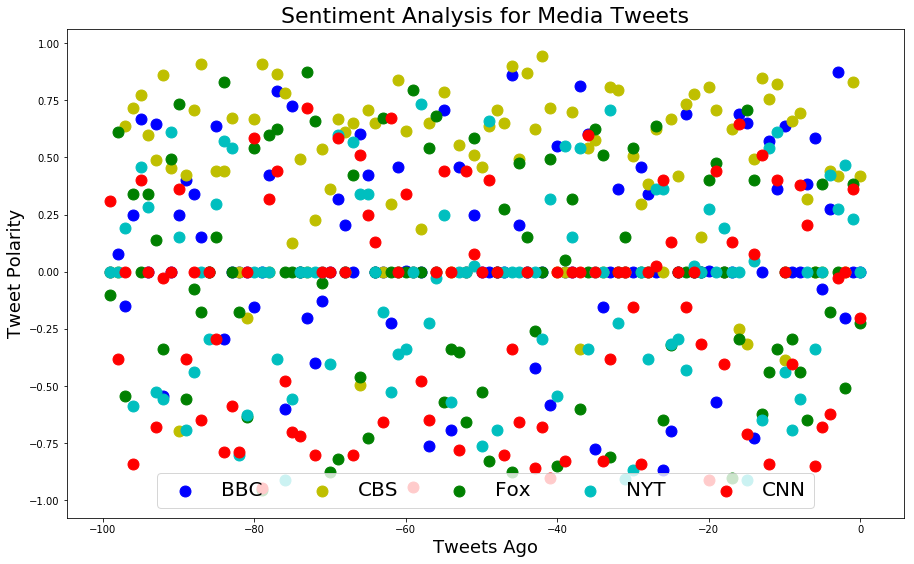

In [17]:
plt.rcParams['figure.figsize']=(15,9)
#df.plot.scatter(x='tago',y='BBC',c=['g'],s=50)
#ax = df.plot(kind='scatter', x='tago', y='BBC', color='r')    
#df.plot(kind='scatter', x='tago', y='CBS',color='g')
fig = plt.figure()
ax = fig.add_subplot(111)
sz=120
sz2 = 100 #Requirements call for last 100 tweets
ax.scatter(xr[100:], df['BBC_compound'].tolist()[100:], s=sz, c='b', marker="o", label='BBC')
ax.scatter(xr[100:],df['CBS_compound'].tolist()[100:],s=sz,c='y',marker='o',label='CBS')
ax.scatter(xr[100:],df['Fox_compound'].tolist()[100:],s=sz,c='g',marker='o',label='Fox')
ax.scatter(xr[100:],df['NYTimes_compound'].tolist()[100:],s=sz,c='c',marker='o',label='NYT')
ax.scatter(xr[100:],df['CNN_compound'].tolist()[100:],s=sz,c='r',marker='o',label='CNN')
plt.legend(loc='lower center',ncol=2);
ax.legend(frameon=True, loc='lower center', ncol=5, fontsize=20)
ax.set_title('Sentiment Analysis for Media Tweets',fontsize=22)
ax.set_xlabel('Tweets Ago',fontsize=18)
ax.set_ylabel('Tweet Polarity',fontsize=18)
plt.show()


# Save Scatterplot

In [18]:
fig.savefig('sentiment_analysis_scatter.png')

# Bar Chart (using Seaborn)

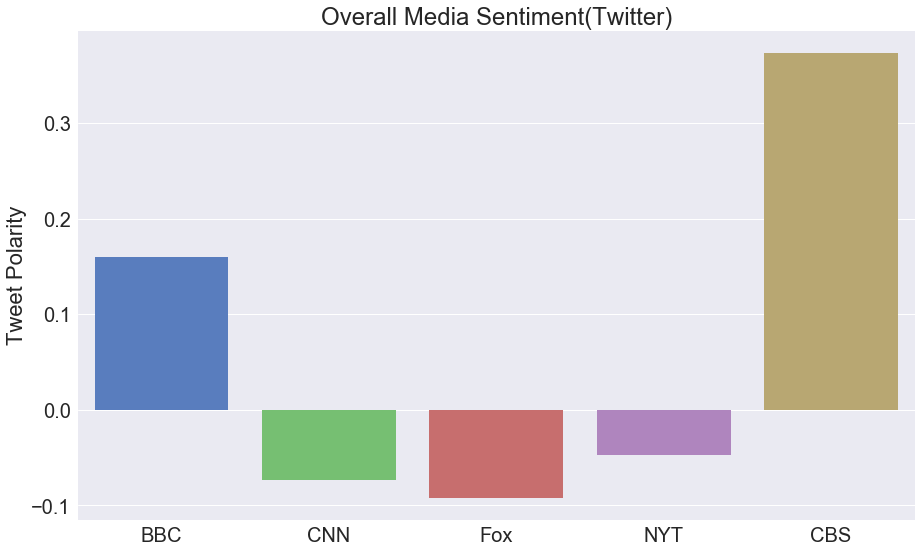

In [19]:
import seaborn as sns
bbc_mean = sum(df['BBC_compound'].tolist()[0:sz2])/sz2
cnn_mean = sum(df['CNN_compound'].tolist()[0:sz2])/sz2
fox_mean = sum(df['Fox_compound'].tolist()[0:sz2])/sz2
nyt_mean = sum(df['NYTimes_compound'].tolist()[0:sz2])/sz2
cbs_mean = sum(df['CBS_compound'].tolist()[0:sz2])/sz2
sns.set_style("darkgrid")
sns.set(font_scale=2)  # kinda big
bar_plot = sns.barplot(x=pd.Series(['BBC','CNN','Fox','NYT','CBS']),\
                       y=pd.Series([bbc_mean,cnn_mean,fox_mean,nyt_mean,cbs_mean]),\
                       palette = "muted")
bar_plot.set(ylabel='Tweet Polarity',title='Overall Media Sentiment(Twitter)')

plt.xticks(rotation=0)
plt.show()

# Save Seaborn BarPlot

In [20]:
fig = bar_plot.get_figure()
fig.savefig('sentiment_analysis_bar.png')

# Save DataFrame to CSV

In [21]:
df.to_csv('sentiment_analysis.csv')

In [ ]:
count = 0
for i in range(5001, 100000):
    is_ = str(i)
    if is_.count('0') != 0 or is_.count('1') != 0 or is_.count('2') != 0 or \
       is_.count('8') != 0 or is_.count('9') != 0:
            continue
    elif is_.count('3') >= 2 or is_.count('4') >=2 or is_.count('5') >= 2 or \
           is_.count('6') >= 2 or is_.count('7'):
            continue
    else:
        count += 1